# Load Sentinel-2 data from the Planetary Computer STAC catalog

This notebook shows an example how to load Sentinel-2 L2A data from the [Planetary Computer STAC API](https://planetarycomputer.microsoft.com/).

## Setup
In order to run this notebook you may install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac), following the [README](../../README.md).

Now, we first import everything we need:

In [1]:
%%time

import matplotlib.pyplot as plt
import xarray as xr
from xcube.core.store import new_data_store, get_data_store_params_schema

from xcube_stac.utils import reproject_bbox

CPU times: user 6.96 s, sys: 524 ms, total: 7.48 s
Wall time: 5.83 s


In [2]:
xr.set_options(display_expand_attrs=False)

There are two [data stores](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework) available for the [Planetary Computer STAC API](https://planetarycomputer.microsoft.com/):

- **`stac-pc-ardc`**: Allows you to open multiple STAC items and assemble them into a 3D spatiotemporal data cube.
- **`stac-pc`**: Enables you to open individual STAC items.

---
## Data store to access spatiotemporal analysis-ready data cubes 
In the following, we will first demonstrate how to use the `stac-pc-ardc` store. To initialize the data store instance, no parameters are needed as indecated in the following cell. 

In [3]:
%%time
store_params = get_data_store_params_schema("stac-pc-ardc")
store_params

CPU times: user 119 ms, sys: 18 ms, total: 137 ms
Wall time: 135 ms


In [4]:
%%time
store = new_data_store("stac-pc-ardc")

CPU times: user 23 ms, sys: 3.09 ms, total: 26.1 ms
Wall time: 230 ms


The following cell shows the available data IDs for the analysis-ready datacube mode. The data IDs point to a STAC collections.

In [5]:
%%time
data_ids = store.list_data_ids()
data_ids

CPU times: user 29 μs, sys: 3 μs, total: 32 μs
Wall time: 35 μs


['sentinel-2-l2a']

Below, the parameters for the `open_data` method can be viewed for a specific data ID.

In [6]:
%%time
open_params = store.get_open_data_params_schema("sentinel-2-l2a")
open_params

CPU times: user 74 μs, sys: 7 μs, total: 81 μs
Wall time: 86.3 μs


The store supports the collection `sentinel-2-l2a`. We set the bounding box to cover the greater Hamburg area and the time range to second half of July 2020.

In [7]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=[9.7, 53.3, 10.3, 53.8],
    time_range=["2020-07-15", "2020-08-01"],
    spatial_res=10 / 111320,  # meter in degree
    crs="EPSG:4326",
    asset_names=["B02", "B03", "B04"],
    add_angles=True,
)
ds

CPU times: user 7.86 s, sys: 137 ms, total: 8 s
Wall time: 13.7 s


<xarray.Dataset> Size: 3GB
Dimensions:        (time: 7, lon: 6681, lat: 5567, angle_lon: 15,
                    angle_lat: 13, angle: 2, band: 3)
Coordinates:
  * time           (time) datetime64[ns] 56B 2020-07-16T10:40:31.024000 ... 2...
    spatial_ref    int64 8B 0
  * lon            (lon) float64 53kB 9.7 9.7 9.7 9.7 ... 10.3 10.3 10.3 10.3
  * lat            (lat) float64 45kB 53.8 53.8 53.8 53.8 ... 53.3 53.3 53.3
  * angle_lon      (angle_lon) float64 120B 9.7 9.746 9.791 ... 10.29 10.34
  * angle_lat      (angle_lat) float64 104B 53.84 53.79 53.75 ... 53.34 53.3
  * angle          (angle) object 16B 'zenith' 'azimuth'
  * band           (band) <U3 36B 'B02' 'B03' 'B04'
Data variables:
    B02            (time, lat, lon) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03            (time, lat, lon) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04            (time, lat, lon) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    solar_angle    (angle, time, angle_lat, angle_lon) float32 11kB dask.array<chunksize=(2, 1, 13, 15), meta=np.ndarray>
    viewing_angle  (angle, band, time, angle_lat, angle_lon) float32 33kB dask.array<chunksize=(2, 3, 1, 13, 15), meta=np.ndarray>
Attributes: (3)

We can plot the B04 (red) band for a given timestamp as an example. Hereby a mosaicking of multiple tiles have been applied. Additionally, we plot the solar and viewing angle.

CPU times: user 8.96 s, sys: 1.8 s, total: 10.8 s
Wall time: 9.05 s


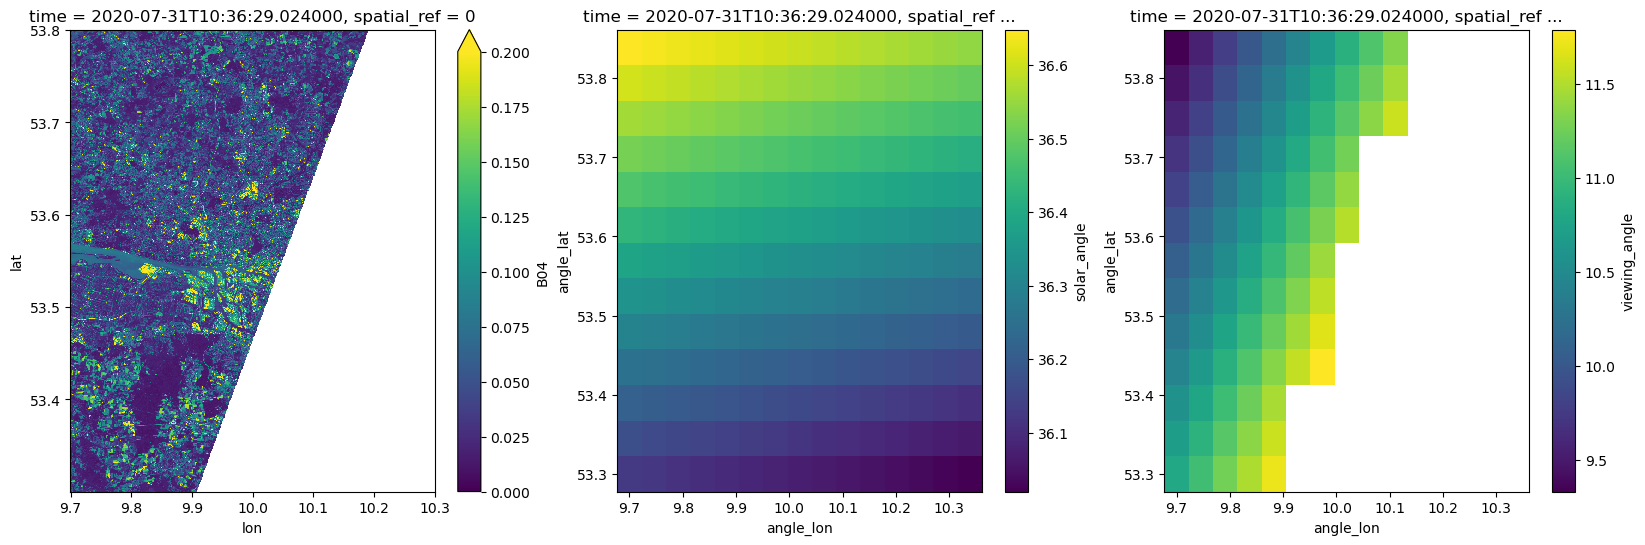

/home/konstantin/micromamba/envs/xcube-stac/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [8]:
%%time
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ds.B04.isel(time=-1)[::10, ::10].plot(ax=ax[0], vmin=0, vmax=0.2)
ds.solar_angle.isel(angle=0, time=-1).plot(ax=ax[1])
ds.viewing_angle.isel(band=2, angle=0, time=-1).plot(ax=ax[2])

The data access can be sped up when requesting the data in the UTM CRS which is the native UTM of the Sentinel-2 products. 

In [9]:
%%time
bbox = [9.7, 53.3, 10.3, 53.8]
crs_target = "EPSG:32632"
bbox_utm = reproject_bbox(bbox, "EPSG:4326", crs_target)

CPU times: user 1.46 ms, sys: 49 μs, total: 1.51 ms
Wall time: 788 μs


In [10]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox_utm,
    time_range=["2020-07-15", "2020-08-01"],
    spatial_res=10,
    crs=crs_target,
    asset_names=["B02", "B03", "B04", "SCL"],
    add_angles=True,
)
ds

CPU times: user 6.44 s, sys: 190 ms, total: 6.63 s
Wall time: 12.7 s


<xarray.Dataset> Size: 3GB
Dimensions:        (time: 11, y: 5619, x: 4054, angle_x: 10, angle_y: 13,
                    angle: 2, band: 3)
Coordinates:
  * time           (time) datetime64[ns] 88B 2020-07-15T10:15:59.024000 ... 2...
    spatial_ref    int64 8B 0
  * x              (x) float64 32kB 5.461e+05 5.461e+05 ... 5.866e+05 5.866e+05
  * y              (y) float64 45kB 5.962e+06 5.962e+06 ... 5.906e+06 5.906e+06
  * angle_x        (angle_x) float64 80B 5.461e+05 5.511e+05 ... 5.911e+05
  * angle_y        (angle_y) float64 104B 5.966e+06 5.961e+06 ... 5.906e+06
  * angle          (angle) object 16B 'zenith' 'azimuth'
  * band           (band) <U3 36B 'B02' 'B03' 'B04'
Data variables:
    B02            (time, y, x) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03            (time, y, x) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04            (time, y, x) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL            (time, y, x) uint8 251MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    solar_angle    (angle, time, angle_y, angle_x) float32 11kB dask.array<chunksize=(2, 1, 13, 10), meta=np.ndarray>
    viewing_angle  (angle, band, time, angle_y, angle_x) float32 34kB dask.array<chunksize=(2, 3, 1, 13, 10), meta=np.ndarray>
Attributes: (3)

We can plot the B04 (red) band for a given timestamp as an example. Hereby a mosaicking of multiple tiles have been applied. Additionally, we plot the solar and viewing angle.

CPU times: user 994 ms, sys: 395 ms, total: 1.39 s
Wall time: 6.54 s


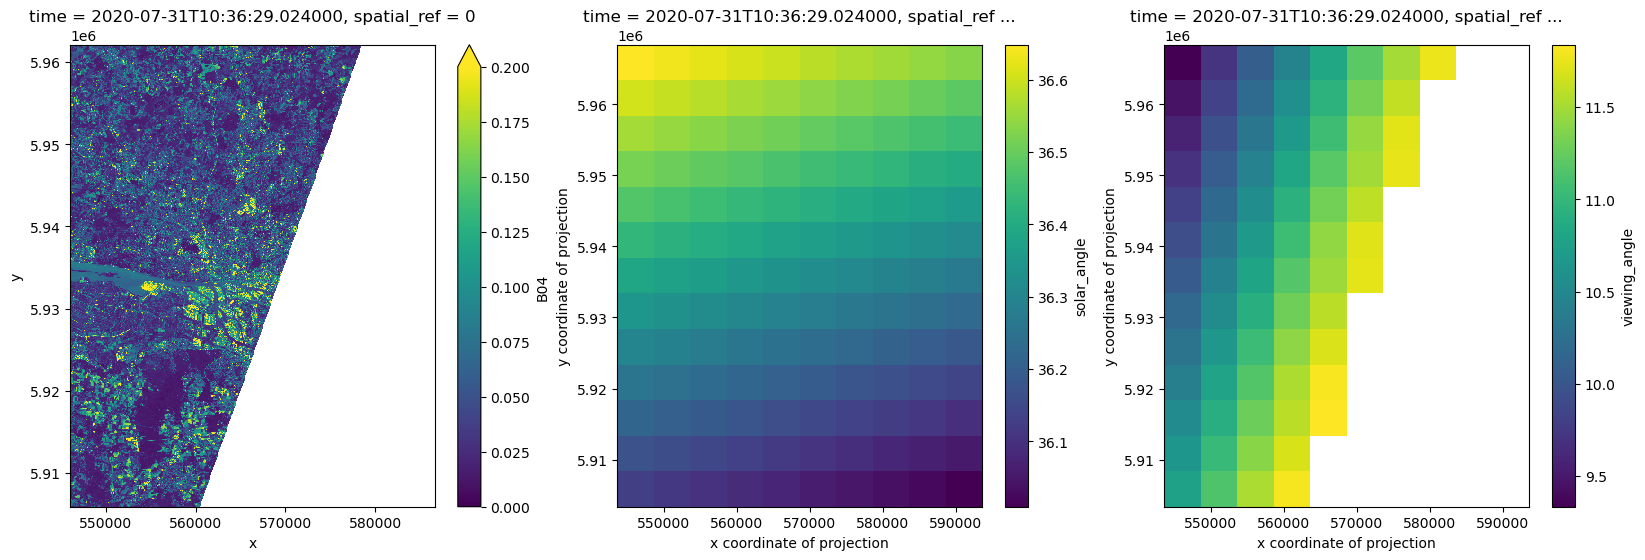

In [11]:
%%time
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ds.B04.isel(time=-1)[::10, ::10].plot(ax=ax[0], vmin=0, vmax=0.2)
ds.solar_angle.isel(angle=0, time=-1).plot(ax=ax[1])
ds.viewing_angle.isel(band=2, angle=0, time=-1).plot(ax=ax[2])

----
## Data store to access single observations
Now, we initiate the data store to access each STAC item representing one observation tile. 

In [12]:
%%time
store = new_data_store("stac-pc")

CPU times: user 7.79 ms, sys: 176 μs, total: 7.97 ms
Wall time: 1.4 s


In the next step, we can search for items using search parameters. The following code shows which search parameters are available.

In [13]:
%%time
search_params = store.get_search_params_schema()
search_params

CPU times: user 28 μs, sys: 3 μs, total: 31 μs
Wall time: 33.4 μs


 Next, we will search for tiles of Sentinel-2 data. The data IDs point to a [STAC item's JSON](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) and are specified by the segment of the URL that follows the catalog's URL.

In [14]:
%%time
descriptors = list(
    store.search_data(
        collections=["sentinel-2-l2a"],
        bbox=[9, 47, 10, 48],
        time_range=["2020-07-01", "2020-07-05"],
    )
)
[d.to_dict() for d in descriptors]

CPU times: user 224 ms, sys: 10.1 ms, total: 234 ms
Wall time: 12 s


[{'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_R065_T32UNU_20200825T083509',
  'data_type': 'dataset',
  'bbox': [8.999727904106205,
   47.75581864580811,
   10.493269475577202,
   48.7530130044756],
  'time_range': ('2020-07-05T10:15:59.024000Z', None)},
 {'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_R065_T32UMU_20200908T152920',
  'data_type': 'dataset',
  'bbox': [8.087774063051185,
   47.75962160343545,
   9.132782609970734,
   48.75293650976542],
  'time_range': ('2020-07-05T10:15:59.024000Z', None)},
 {'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_R065_T32TNT_20200825T083504',
  'data_type': 'dataset',
  'bbox': [8.999732642342602,
   46.85663988190739,
   10.467277376768235,
   47.85370184248753],
  'time_range': ('2020-07-05T10:15:59.024000Z', None)},
 {'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_R065_T32TMT_20200825T083452',
  'data_type': 'dataset',
  'bbox': [7.7607886

In the next step, we can open the data for each data ID. The following code shows which parameters are available for opening the data.

In [15]:
%%time
open_params = store.get_open_data_params_schema()
open_params

CPU times: user 34 μs, sys: 4 μs, total: 38 μs
Wall time: 40.1 μs


We select the band B04 (red), B03 (green), B02 (blue), and the science classification layer (SLC), and lazily load the corresponding data.

In [16]:
%%time
ds = store.open_data(
    "collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_R065_T32TMT_20200825T083452",
    asset_names=["B04", "B03", "B02", "SCL"],
    add_angles=True,
)
ds

CPU times: user 392 ms, sys: 12.3 ms, total: 404 ms
Wall time: 2.64 s


<xarray.Dataset> Size: 2GB
Dimensions:        (y: 10980, x: 10980, angle_x: 23, angle_y: 23, angle: 2,
                    band: 3)
Coordinates:
  * x              (x) float64 88kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.098e+05
  * y              (y) float64 88kB 5.3e+06 5.3e+06 ... 5.19e+06 5.19e+06
    spatial_ref    int64 8B 0
  * angle_x        (angle_x) float64 184B 4e+05 4.05e+05 ... 5.05e+05 5.1e+05
  * angle_y        (angle_y) float64 184B 5.3e+06 5.295e+06 ... 5.19e+06
  * angle          (angle) object 16B 'zenith' 'azimuth'
  * band           (band) <U3 36B 'B02' 'B03' 'B04'
Data variables:
    B04            (y, x) float32 482MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B03            (y, x) float32 482MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B02            (y, x) float32 482MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    SCL            (y, x) uint8 121MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    solar_angle    (angle, angle_y, angle_x) float32 4kB dask.array<chunksize=(2, 23, 23), meta=np.ndarray>
    viewing_angle  (angle, band, angle_y, angle_x) float32 13kB dask.array<chunksize=(2, 3, 23, 23), meta=np.ndarray>
Attributes: (3)

We plot the loaded data as an example below.

CPU times: user 3.5 s, sys: 1.6 s, total: 5.1 s
Wall time: 35.4 s


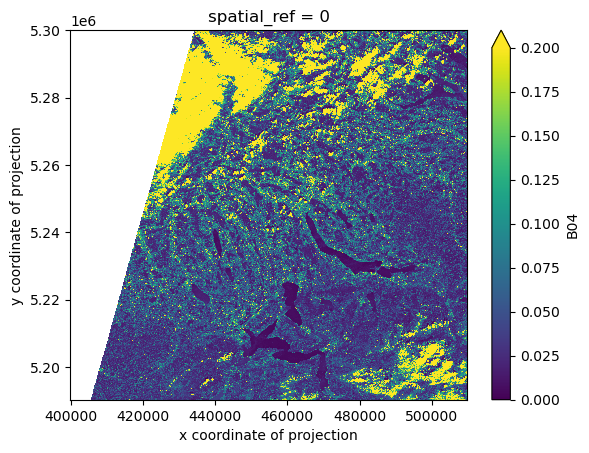

In [17]:
%%time
ds.B04[::10, ::10].plot(vmin=0.0, vmax=0.2)